# HW11 Problem 6: Neural Networks and Stochastic Gradient Descent

This notebook contains the **full solution** for HW11 Problem 6.





### Outline of this Notebook


* [HW11: Problem 6: MLP with LBFGS](#part1): How many hidden units should we pick?


In [ ]:
# Don't modify this cell; just run it to set up the environment
import os
import numpy as np
import pandas as pd
import time
import warnings

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, zero_one_loss
import sklearn.metrics
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

# print("Styles available:", plt.style.available)
plt.style.use('seaborn-v0_8-dark') # pretty matplotlib plots
sns.set('notebook', font_scale=1.25, style='whitegrid')
## This is a utility function for visualizing classification.
## Execute this cell but do not modify it.
def plot_pretty_probabilities_for_clf(
        clf, x_tr_N2, y_tr_N,
        ax=None,
        x1_grid=(-2, 2, 50), x2_grid=(-2, 2, 50),
        x1_ticks=[-1, 0, 1], x2_ticks=[-1, 0, 1],
        do_show_colorbar=False,
        c_ticks=np.asarray([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        c_num_levels=100,
        ):
    ''' Display predicted probabilities from classifier as color contour plot

    Args
    ----
    clf : sklearn object that implements classifier API
    x_tr_N2 : 2D array, size N x 2
        Features for each training example (a length-2 vector)
    y_tr_N : 1D array, size N
        Labels for each training example (binary, 0 or 1)
    ax : matplotlib axis handle, or None
        If provided, will use axis handle as primary axis to plot on.
        If None, will use the current handle, or make new one as necessary.
    x1_grid : tuple-like or array-like
        If tuple of length 3, interpreted as args to np.linspace
        Otherwise, cast to array and assumed to be a 1d grid of x1 values
    x2_grid : tuple-like or array-like
        If tuple of length 3, interpreted as args to np.linspace
        Otherwise, cast to array and assumed to be a 1d grid of x2 values

    '''
    # Activate the current axis, if necessary
    if ax is None:
        cur_ax = plt.gca()
    else:
        cur_ax = ax
        plt.sca(cur_ax)

    # Plot the training data, colored by true label
    cur_ax.plot(x_tr_N2[y_tr_N==0, 0], x_tr_N2[y_tr_N==0,1], 'rx', mew=2)
    cur_ax.plot(x_tr_N2[y_tr_N==1, 0], x_tr_N2[y_tr_N==1,1], 'b+', mew=2)

    # Make predictions and compute error rates and losses
    tr_loss = sklearn.metrics.log_loss(y_tr_N, clf.predict_proba(x_tr_N2)[:,1])
    tr_err = sklearn.metrics.zero_one_loss(y_tr_N, clf.predict(x_tr_N2))
    cur_ax.set_title(
        'log loss %.3f  err_rate %.3f' % (tr_loss, tr_err))

    # Visualize predicted probabilities
    if isinstance(x1_grid, tuple) and len(x1_grid) == 3:
        x1_grid = np.linspace(x1_grid[0], x1_grid[1], x1_grid[2])
    if isinstance(x2_grid, tuple) and len(x2_grid) == 3:
        x2_grid = np.linspace(x2_grid[0], x2_grid[1], x2_grid[2])
    x1_grid = np.asarray(x1_grid).flatten()
    x2_grid = np.asarray(x2_grid).flatten()

    c_levels = np.linspace(0.0, 1.0, c_num_levels)

    # Get regular grid of G x H points, where each point is an (x1, x2) location
    G = x1_grid.size
    H = x2_grid.size
    x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)

    # Combine the x1 and x2 values into one array
    # Flattened into M = G x H rows
    # Each row of x_M2 is a 2D vector [x_m1, x_m2]
    x_M2 = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])

    # Predict proba for each point in the flattened grid
    yproba1_M = clf.predict_proba(x_M2)[:,1]
    # Reshape the M probas into the GxH 2D field
    yproba1_GH = np.reshape(yproba1_M, x1_GH.shape)
    # Contour plot
    cmap = plt.cm.RdYlBu
    my_contourf_h = plt.contourf(x1_GH, x2_GH, yproba1_GH, levels=c_levels, vmin=0, vmax=1.0, cmap=cmap)
    # Edit the ticks observed
    if x1_ticks is not None:
        plt.xticks(x1_ticks, x1_ticks);
    if x2_ticks is not None:
        plt.yticks(x2_ticks, x2_ticks);
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left + 1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);

`'seaborn-dark'` throws an error, so changed it to `'seaborn-v0_8-dark'`.

# Load the "Flower XOR" dataset


10,000 labeled examples in training set

Each example has 2 features ($x_{n1}, x_{n2}$)

Each label is binary (0 or 1)

In [ ]:
DATA_DIR = "data_flower"

In [ ]:
# Load training data
x_tr_N2 = np.loadtxt(os.path.join(DATA_DIR, 'x_train.csv'), skiprows=1, delimiter=',')
y_tr_N = np.loadtxt(os.path.join(DATA_DIR, 'y_train.csv'), skiprows=1, delimiter=',')

# Load test data
x_te_T2 = np.loadtxt(os.path.join(DATA_DIR, 'x_test.csv'), skiprows=1, delimiter=',')
y_te_T = np.loadtxt(os.path.join(DATA_DIR, 'y_test.csv'), skiprows=1, delimiter=',')

assert x_tr_N2.shape[0] == y_tr_N.shape[0]
assert x_te_T2.shape[0] == y_te_T.shape[0]

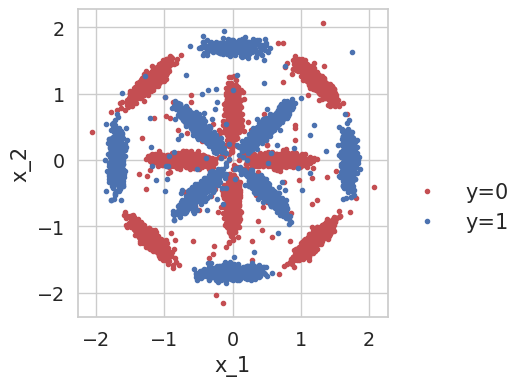

In [ ]:
fig, _ = plt.subplots(figsize=(4,4));
plt.plot(x_tr_N2[y_tr_N == 0,0], x_tr_N2[y_tr_N == 0,1], 'r.', label='y=0');
plt.plot(x_tr_N2[y_tr_N == 1,0], x_tr_N2[y_tr_N == 1,1], 'b.', label='y=1');
plt.legend(bbox_to_anchor=[1.0, 0.5], fontsize=15);
plt.xlabel('x_1'); plt.ylabel('x_2');

# MLP with L-BFGS solver - What model size is best?

Let's train an MLP at each of several different sizes.

For this problem, we'll use the `solver='lbfgs'`

We'll try multiple runs of the optimizer, to see what the impact of different random initializations of parameters is.

In [ ]:
size_list = [4, 16, 64, 128]
n_runs = 1

S = len(size_list)

# Initialize arrays to store performance metrics
tr_loss_arr = np.zeros((S, n_runs))
te_loss_arr = np.zeros((S, n_runs))
tr_err_arr  = np.zeros((S, n_runs))
te_err_arr  = np.zeros((S, n_runs))
max_iter_per_run = 1000

Task: Initialize the Neural NetworkInstantiate a new MLPClassifier object. You must configure the network architecture and training behavior with the following specific requirements:

* Architecture: Define a single hidden layer using the provided size variable. Set the activation function to Rectified Linear Unit.
* Solver: Use the LBFGS solver for optimization and set the batch size to 10,000.
* Constraints: Set the L2 penalty term (alpha) to 0.0001 and the convergence tolerance to $10^{-5}$.
* Runtime Variables: Pass the provided max_iter_per_run and random_state variables into their corresponding arguments to handle iteration limits and reproducibility.
  


In [ ]:
[x for x in globals().keys() if x.startswith('y')]

['y_tr_N', 'y_te_T']

In [ ]:
for size_id, size in enumerate(size_list):
    for run_id, random_state in enumerate(range(n_runs)):
        start_time_sec = time.time()

        # Create an MLPClassifier with the specified parameters.
        # Assign the created classifier to a variable named `mlp`.
        mlp = MLPClassifier(
            hidden_layer_sizes = (size,),
            activation = 'relu',
            solver = 'lbfgs',
            batch_size = 10000,
            alpha = 0.0001,
            tol = 1e-5,
            max_iter = max_iter_per_run,
            random_state = random_state
        )

        with warnings.catch_warnings(record=True) as warn_list:
            # Train the `mlp` classifier using `x_tr_N2` and `y_tr_N`.
            mlp.fit(x_tr_N2, y_tr_N)

        # The following lines are provided for you and should not be modified.
        elapsed_time_sec = time.time() - start_time_sec # To prevent crashing for before your code
        if 'mlp' in locals() and mlp is not None:  # To prevent crashing for before your code
            mlp.did_converge = True if len(warn_list) == 0 else False  # To prevent crashing for before your code
        else:
            # Placeholder for `mlp.did_converge` if `mlp` is not yet defined by the student
            class MockMLP:  # To prevent crashing for before your code
                pass  # To prevent crashing for before your code
            mlp = MockMLP() # To prevent crashing for before your code
            mlp.did_converge = False # Indicate not converged as a default

        # Compute the log loss on the training and test set (base-2).
        # You will need to use `mlp.predict_proba()` and `sklearn.metrics.log_loss`.
        # Remember to convert the log loss from base-e to base-2 by dividing by `np.log(2)`.
        tr_log_loss = log_loss(y_tr_N, mlp.predict_proba(x_tr_N2)) / np.log(2)
        te_log_loss = log_loss(y_te_T, mlp.predict_proba(x_te_T2)) / np.log(2)

        # Compute the error rate on the training and test set.
        # You will need to use `mlp.predict()` and `sklearn.metrics.zero_one_loss`.
        # Compute error rate
        tr_err = zero_one_loss(y_tr_N, mlp.predict(x_tr_N2))
        te_err = zero_one_loss(y_te_T, mlp.predict(x_te_T2))

        # raise NotImplementedError('Student must implement MLP training and evaluation.')

        # Store performance metrics (do not modify this part)
        tr_loss_arr[size_id, run_id] = tr_log_loss
        te_loss_arr[size_id, run_id] = te_log_loss
        tr_err_arr[size_id, run_id]  = tr_err
        te_err_arr[size_id, run_id]  = te_err

        print('layer_sizes %3d: run %d/%d done after %5.1f sec | %13s after %3d iter | tr err %.3f | te err %.3f' % (
            size,
            run_id + 1, n_runs, elapsed_time_sec,
            'yes converged' if mlp.did_converge else 'NOT converged',
            max_iter_per_run,
            tr_err, te_err)
        )

layer_sizes   4: run 1/1 done after   1.0 sec | yes converged after 1000 iter | tr err 0.258 | te err 0.267
layer_sizes  16: run 1/1 done after   4.2 sec | yes converged after 1000 iter | tr err 0.015 | te err 0.015
layer_sizes  64: run 1/1 done after  36.2 sec | NOT converged after 1000 iter | tr err 0.008 | te err 0.015
layer_sizes 128: run 1/1 done after  58.4 sec | NOT converged after 1000 iter | tr err 0.006 | te err 0.016


## For fun and understanding, visualize the latest run's learned MLP

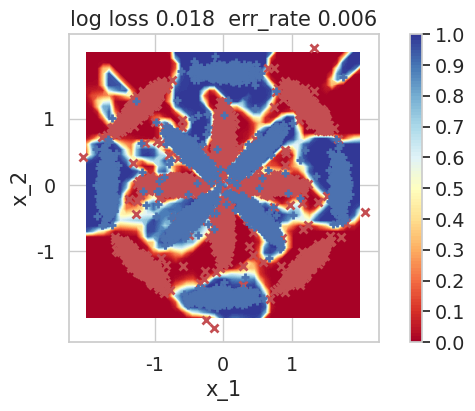

In [ ]:
fig, ax_handle = plt.subplots(nrows=1, ncols=1, figsize=(4, 4));
plot_pretty_probabilities_for_clf(mlp, x_tr_N2, y_tr_N, ax=ax_handle, do_show_colorbar=True);
plt.xlabel('x_1'); plt.ylabel('x_2');

This plot shows how the MLP with 128 hidden units separates the data. Even though the model did not converge within 1000 iterations, it still learned a detailed boundary that closely matches the complex star-shaped structure of the actual data.

It also has a very low error rate.

In [ ]:
mlp

MLPClassifier(batch_size=10000, hidden_layer_sizes=(128,), max_iter=1000,
              random_state=0, solver='lbfgs', tol=1e-05)

## Figure 1 (left): Log loss vs size

TODO if you've filled in the `tr_loss_arr` and `te_loss_arr` correctly so it has shape (S,R) with S sizes and R runs, this code should make a nice plot for you.

Each dot in the plot represents one completed run of the optimizer from a random initialization.


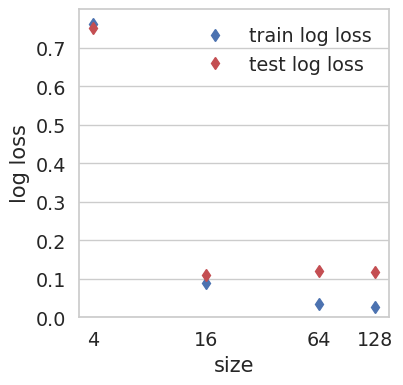

In [ ]:
fig, loss_ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), sharex=True, sharey=True)

for run_id in range(n_runs):
    tr_label = 'train log loss' if run_id == 0 else ''
    te_label = 'test log loss' if run_id == 0 else ''

    loss_ax.plot(np.log2(size_list), tr_loss_arr[:,run_id], 'bd', label=tr_label)
    loss_ax.plot(np.log2(size_list), te_loss_arr[:,run_id], 'rd', label=te_label)

loss_ax.set_xticks(np.log2(size_list));
loss_ax.set_xticklabels(size_list);
loss_ax.xaxis.grid(False);

loss_ax.set_ylim([0, 0.8]); # Don't touch this please
loss_ax.set_yticks(np.arange(0, 0.8, 0.1));

loss_ax.set_ylabel('log loss');
loss_ax.set_xlabel('size');
loss_ax.legend(loc='upper right');

When the model is very small like size 4, the log loss is high. This means it cannot learn the pattern well.
When the model gets bigger to size 16, the log loss becomes much lower. This size learns the data much better.
When we make the model even bigger like 64 or 128, the training log loss goes down a little more, but the test log loss does not really get better. So the bigger models do not help much, even though they try harder to fit the data.

## Figure 1 (right): Error vs size

TODO if you've filled in the `tr_err_arr` and `te_err_arr` correctly so it has shape (S,R) with S sizes and R runs, this code should make a nice plot for you.


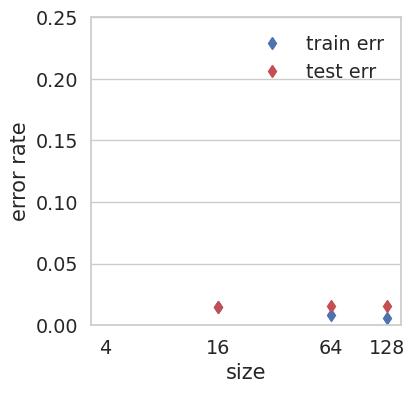

In [ ]:
fig, err_ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), sharex=True, sharey=True)

for run_id in range(n_runs):
    tr_label = 'train err' if run_id == 0 else ''
    te_label = 'test err' if run_id == 0 else ''

    err_ax.plot(np.log2(size_list), tr_err_arr[:,run_id], 'bd', label=tr_label)
    err_ax.plot(np.log2(size_list), te_err_arr[:,run_id], 'rd', label=te_label)

err_ax.set_xticks(np.log2(size_list));
err_ax.set_xticklabels(size_list);
err_ax.xaxis.grid(False);

err_ax.set_ylim([0, 0.25]); # Don't touch this please

err_ax.set_ylabel('error rate');
err_ax.set_xlabel('size');
err_ax.legend(loc='upper right');

This plot tells the same story as the log loss plot. The small model at size 4 has a higher error rate (over 0.25). When we move to size 16, the error rate becomes very low. After that, making the model bigger does not really help. The models with size 64 and 128 do a bit better on the training set, but the test error stays almost the same. So again, size 16 gives the best and most steady results.

The models with 64 and 128 hidden units would work relatively better if they converged within 1000 iterations. However, the improvement would not be very large. And these bigger models also start to show small signs of overfitting.